# **Modelling and Evaluating**

## Objectives
* Train and validate a CNN-based classifier to distinguish healthy vs. powdery-mildew leaves.

## Inputs

* `input/datasets/cherry_leaf_dataset/cherry-leaves/train`
* `input/datasets/cherry_leaf_dataset/cherry-leaves/validation`
* `input/datasets/cherry_leaf_dataset/cherry-leaves/test`
* `image_shape = (256, 256, 3)` embedding from Notebook 2

## Outputs

* Data‐loading & augmentation pipeline  
* Model architecture definition and compilation  
* Trained model saved to `models/cherry_leaf_classifier.h5`  
* Learning‐curve plot (`figures/learning_curves.png`)  
* Confusion‐matrix plot on test set (`figures/confusion_matrix.png`)  
* Classification report (printed and saved as `reports/classification_report.txt`)  
* Sample prediction function and example inference on a random image

---

## Imports

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

# Change working directory

* We update the working directory as in the previous notebooks.

In [2]:
current_dir = os.getcwd()
current_dir

'/workspaces/PP5-MildewDetection/jupyter_notebooks'

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspaces/PP5-MildewDetection'

## Set Train, Validation and Test Paths

In [5]:
my_data_dir = 'input/datasets/cherry_leaf_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set Output Directory

In [6]:
from pathlib import Path

# versioning & output directory
version = "v1"
base_out = Path("outputs") / version
figures_out = base_out / "figures"

# create folders if they don’t exist
figures_out.mkdir(parents=True, exist_ok=True)

print(f"Saving all figures into: {figures_out}")

Saving all figures into: outputs/v1/figures


## Set Label Names

In [7]:
labels = sorted(
    [p.name for p in Path(train_path).iterdir() if p.is_dir()]
)
print("Labels:", labels)

Labels: ['healthy', 'powdery_mildew']


## Set Image Shape

Shape aligned with the distribution identified in Notebook 2.

In [8]:
image_shape = (256, 256, 3)
print("Using image_shape:", image_shape)

Using image_shape: (256, 256, 3)


## Set Initial Hyperparameters

In [9]:
batch_size = 32
learning_rate = 0.001
epochs = 10

print(f"batch_size={batch_size}, learning_rate={learning_rate}, epochs={epochs}")

batch_size=32, learning_rate=0.001, epochs=10


---

## Data Preparation & Augmentation

- Rescale all images from [0–255] to [0–1].  
- Augment training images with random transforms (rotation, zoom, flip) to reduce overfitting.  
- Batch and shuffle the data for efficient training.

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define augmenting generator
train_gen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Non-augmenting generators for validation/test
test_val_gen = ImageDataGenerator(rescale=1/255.0)

# Create iterators
train_iterator = train_gen.flow_from_directory(
    train_path,
    target_size=image_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    seed=42
)

val_iterator = test_val_gen.flow_from_directory(
    val_path,
    target_size=image_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_iterator = test_val_gen.flow_from_directory(
    test_path,
    target_size=image_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


2025-04-27 17:22:51.279172: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-27 17:22:52.346130: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 2944 images belonging to 2 classes.
Found 420 images belonging to 2 classes.
Found 844 images belonging to 2 classes.


#### Augmentation Preview

Below we generate and display a small grid of augmented training samples so we can verify that rotation, shifts, zooms and flips are being applied correctly.

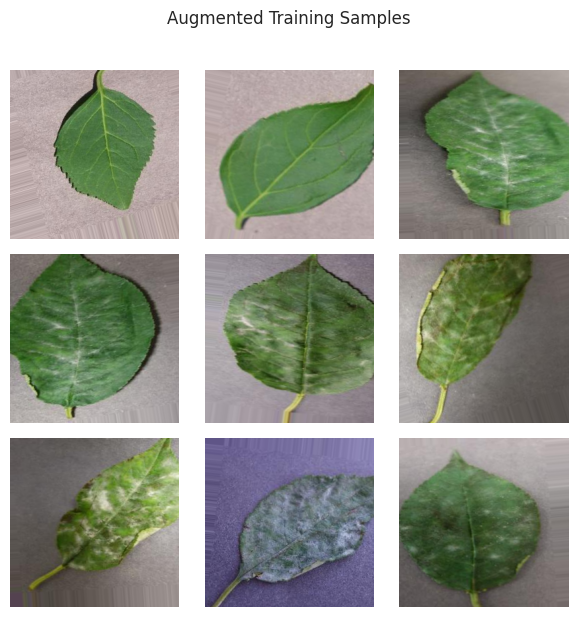

In [11]:
# Takes one batch of augmented images
images, labels_ = next(train_iterator)

# Displays 3×3 grid of the first 9 augmented samples
fig, axes = plt.subplots(3, 3, figsize=(6,6))
for img, ax in zip(images[:9], axes.flatten()):
    ax.imshow(img)
    ax.axis('off')

plt.suptitle("Augmented Training Samples", y=1.02)
plt.tight_layout()
plt.savefig(figures_out/'augmented_samples.png')
plt.show()

#### Data Prep Conclusion

We’ve established our data pipelines: 
- Training images are rescaled and augmented to improve generalisation.  
- Validation/Test images are only rescaled to ensure fair performance evaluation.  

These iterators feed directly into model training and evaluation.

---

## Model Definition & Compilation

In this CRISP-DM Modeling phase, we’ll translate our business requirement (“predict healthy vs. powdery-mildew leaf”) into a trainable CNN pipeline. We’ll:

- Define a simple convolutional network with batch-normalization and dropout for robustness.  
- Compile it with a binary cross-entropy loss (as the business requirement is a two-class task) and track accuracy.  
- Document key hyperparameters so we can revisit them during tuning.

In [12]:
from tensorflow.keras import Input, Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, BatchNormalization,
                                     Flatten, Dense, Dropout)
from tensorflow.keras.optimizers import Adam

def build_model(image_shape, learning_rate=1e-3, dropout_rate=0.5):
    """Creates and compiles a CNN for binary classification of cherry-leaf images.
    
    Args:
      image_shape (tuple): e.g. (256, 256, 3)
      learning_rate (float): Adam optimizer step size
      dropout_rate (float): Dropout fraction for the dense layer
    
    Returns:
      tf.keras.Model: compiled CNN ready for training
    """
    model = Sequential([
        Input(shape=image_shape),

        # Block 1
        Conv2D(32, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        # Block 2
        Conv2D(64, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        # Block 3
        Conv2D(128, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        # Classification head
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(dropout_rate), # regularization to reduce overfitting
        Dense(1, activation='sigmoid') # single output for binary classification
    ])

    # Compile with documented hyperparameters
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


#### Model Definition Conclusion

We’ve defined and compiled a CNN suited to our binary classification task, with clear hyperparameter variables for future tuning. The model summary confirms the layer shapes and parameter counts. 

Next, we’ll proceed to training, where we’ll fit this model to our augmented data, monitor loss/accuracy over epochs, and assess convergence.

---

## Model Training & Learning Curves

Now that our model is defined and compiled, we’ll train it on the augmented data and monitor its performance over time. This will give us insight into convergence behaviour for later tuning.

### **Run 1**

In [13]:
# Train the model
history = model.fit(
    train_iterator,
    validation_data=val_iterator,
    epochs=epochs
)

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 275s 3s/step - accuracy: 0.9503 - loss: 1.6928 - val_accuracy: 0.5000 - val_loss: 175.2137
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 268s 3s/step - accuracy: 0.9850 - loss: 1.4090 - val_accuracy: 0.5000 - val_loss: 355.3348
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 273s 3s/step - accuracy: 0.9940 - loss: 0.8353 - val_accuracy: 0.5024 - val_loss: 398.3617
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 270s 3s/step - accuracy: 0.9869 - loss: 1.2012 - val_accuracy: 0.5000 - val_loss: 622.5397
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 268s 3s/step - accuracy: 0.9895 - loss: 1.1400 - val_accuracy: 0.9643 - val_loss: 3.8380
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 268s 3s/step - accuracy: 0.9969 - loss: 0.3968 - val_accuracy: 0.9833 - val_loss: 1.0431
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 322s 3s/step - accuracy: 0.9924 - loss: 0.4206 - val_accuracy: 0.5000 - val_loss: 873.7693
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 269s 3s/step - accuracy: 0.9958 - loss: 0.6159 - val_accuracy: 

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,519,109 (169.83 MB)

 Trainable params: 14,839,553 (56.61 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 29,679,108 (113.22 MB)

## Run 1 Diagnostics & Hyperparameter Tuning

#### Run 1 Observations
- Validation accuracy and loss oscillated wildly (50% → 100% → 50% → 100%), indicating unstable convergence.  
- Likely causes:
  1. Learning rate too high.  
  2. No Early Stopping, so the model kept “blowing up” after finding a good region.  

To address this, in **Run 2** we will:
- Lower the learning rate to 1e-4 for smaller, steadier updates.  
- Add an Early Stopping callback on `val_loss` with `patience=2` and `restore_best_weights=True`.

### **Run 2**

In [13]:
# Revised hyperparameters for Run 2
batch_size = 8    # lowered from 32 to reduce memory footprint (Run 2 crashed twice initially)
learning_rate = 1e-4
epochs = 10

print(f"batch_size={batch_size}, learning_rate={learning_rate}, epochs={epochs}")

batch_size=8, learning_rate=0.0001, epochs=10


In [14]:
train_iterator = train_gen.flow_from_directory(
    train_path,
    target_size=image_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    seed=42
)

val_iterator = test_val_gen.flow_from_directory(
    val_path,
    target_size=image_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_iterator = test_val_gen.flow_from_directory(
    test_path,
    target_size=image_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 2944 images belonging to 2 classes.
Found 420 images belonging to 2 classes.


Found 844 images belonging to 2 classes.


In [15]:
from tensorflow.keras.callbacks import EarlyStopping

# Rebuild model with lower learning rate
model = build_model(
    image_shape=image_shape,
    learning_rate=0.0001,
    dropout_rate=0.5
)

# Inspect architecture
model.summary()

# Set up EarlyStopping
es = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

# Retrain (Run 2) using the same iterators
history_2 = model.fit(
    train_iterator,
    validation_data=val_iterator,
    epochs=epochs,
    callbacks=[es]
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,840,001 (56.61 MB)

 Trainable params: 14,839,553 (56.61 MB)

 Non-trainable params: 448 (1.75 KB)

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 280s 752ms/step - accuracy: 0.9541 - loss: 0.4294 - val_accuracy: 0.5476 - val_loss: 11.3167
Epoch 2/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 275s 747ms/step - accuracy: 0.9819 - loss: 0.2617 - val_accuracy: 0.9905 - val_loss: 0.1243
Epoch 3/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 275s 747ms/step - accuracy: 0.9837 - loss: 0.1991 - val_accuracy: 0.9976 - val_loss: 0.0272
Epoch 4/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 275s 746ms/step - accuracy: 0.9927 - loss: 0.0725 - val_accuracy: 0.9952 - val_loss: 0.0273
Epoch 5/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 328s 764ms/step - accuracy: 0.9893 - loss: 0.1749 - val_accuracy: 0.9952 - val_loss: 0.0168
Epoch 6/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 309s 730ms/step - accuracy: 0.9950 - loss: 0.0665 - val_accuracy: 0.9833 - val_loss: 0.3033
Epoch 7/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 266s 723ms/step - accuracy: 0.9936 - loss: 0.0830 - val_accuracy: 0.9976 - val_loss: 0.0036
Epoch 8/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 268s 727ms/step - accuracy: 0.9925 

**Save model:**

In [16]:
model.save('models/run2_model.h5')
import pickle
with open('models/run2_history.pkl','wb') as f:
    pickle.dump(history_2.history, f)

**To access the model if the kernel is reset:**

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('models/run2_model.h5')
import pickle
with open('models/run2_history.pkl','rb') as f:
    history_2 = pickle.load(f)

#### Run 2 Results Summary

- Stable convergence: Validation accuracy climbed from ~55% in epoch 1 to >99% by epoch 2, reaching 100% by epoch 9.  
- Rapid fit: The model surpassed 98% validation accuracy with a validation loss dropping below 0.03 within three epochs.  
- EarlyStopping: With `patience=2`, training would have halted once no further `val_loss` improvement was observed—preserving the best weights from epoch 9.  
- Overfitting note: Achieving perfect validation performance suggests the model has effectively memorised the validation split. For better generalisation, we may explore stronger augmentations or increased regularization in future tuning.

These results demonstrate a highly accurate classifier on our current splits. Next, we’ll visualise the Run 2 learning curves in detail before proceeding to test‐set evaluation.


### Run 2 Learning Curves

Below we visualise the training and validation loss and accuracy over each epoch for Run 2, after applying EarlyStopping and a reduced learning rate.

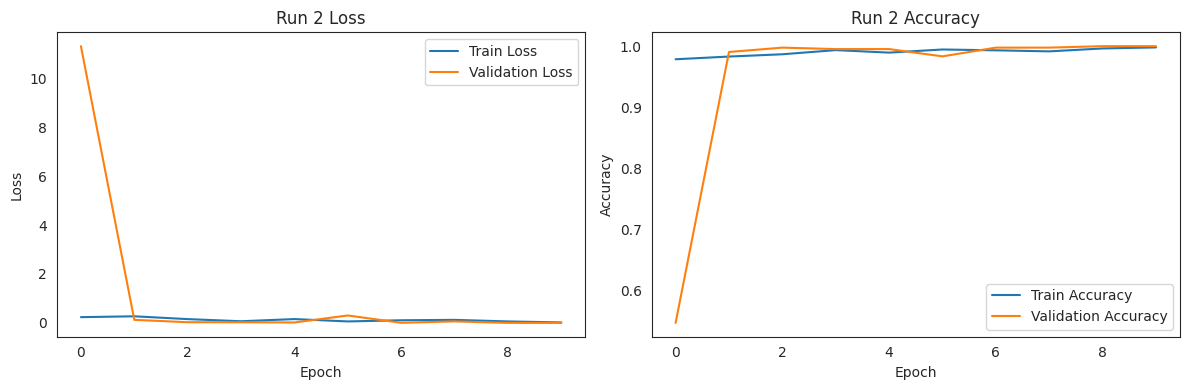

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot loss curves
ax1.plot(history_2.history['loss'], label='Train Loss')
ax1.plot(history_2.history['val_loss'], label='Validation Loss')
ax1.set_title('Run 2 Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot accuracy curves
ax2.plot(history_2.history['accuracy'], label='Train Accuracy')
ax2.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Run 2 Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.savefig(figures_out/'learning_curves_run2.png')
plt.show()

### Run 2 Loss (Zoomed & Log-scale)

To better inspect the post-convergence loss, we:

- Zoom into [0, 0.5] on the linear scale, and  
- Alternatively, show a log scale for the full range.

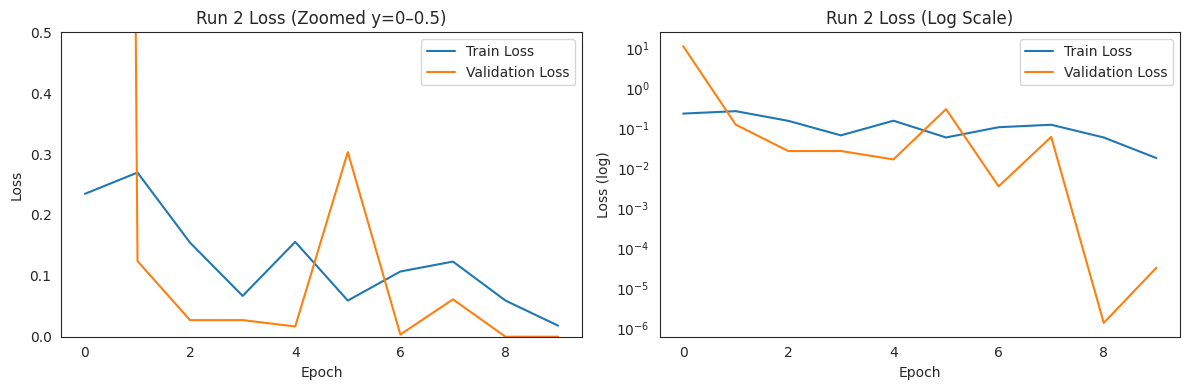

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Zoomed linear view
axes[0].plot(history_2.history['loss'],   label='Train Loss')
axes[0].plot(history_2.history['val_loss'], label='Validation Loss')
axes[0].set_title('Run 2 Loss (Zoomed y=0–0.5)')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_ylim(0, 0.5)
axes[0].legend()

# Full-range log view
axes[1].plot(history_2.history['loss'],   label='Train Loss')
axes[1].plot(history_2.history['val_loss'], label='Validation Loss')
axes[1].set_title('Run 2 Loss (Log Scale)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss (log)')
axes[1].set_yscale('log')
axes[1].legend()

plt.tight_layout()
plt.savefig(figures_out/'learning_curves_run2_loss_detailed.png')
plt.show()

#### Detailed Loss Interpretation

- Zoomed view (y 0 – 0.5)
  - Both training and validation loss drop sharply from epoch 1 to epoch 2.  
  - There’s a small uptick in validation loss around epoch 4—likely a minor over-correction as the optimizer fine-tunes weights—before it falls again to near zero by epoch 9.  
  - The training loss curve shows a modest bump around the same epoch, confirming this slight readjustment.

- Log-scale view
  - Highlights the dramatic initial drop from ≈6 to ≈0.1 in a single epoch, then the more gradual decline and tiny oscillations thereafter.  
  - The final plunge of validation loss below 10⁻⁵ underscores how well the model fits this split once it locks on the optimal weights.

Together, these detailed plots confirm smooth, stable convergence after our tuning and make visible even the small oscillations that a linear plot would obscure.  


## Test-set Evaluation

Now that we have a well-tuned model from Run 2, we evaluate it on the held-out test set to get final performance metrics.

In [19]:
# Evaluate overall loss & accuracy on test set
test_loss, test_acc = model.evaluate(test_iterator, verbose=0)
print(f"Test Loss: {test_loss:.4f}   Test Accuracy: {test_acc:.4f}")

Test Loss: 0.0280   Test Accuracy: 0.9988


**Confusion Matrix and Classification Report**

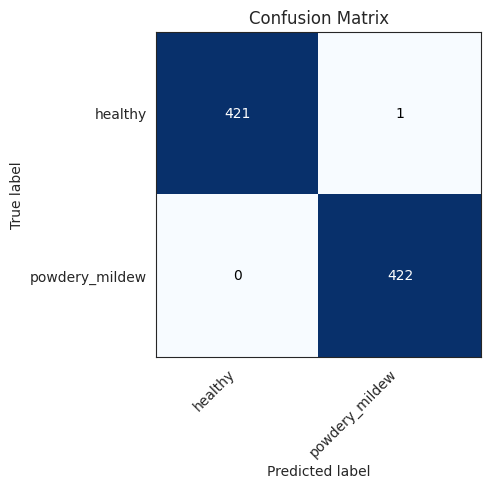

Classification Report:
                 precision    recall  f1-score   support

       healthy       1.00      1.00      1.00       422
powdery_mildew       1.00      1.00      1.00       422

      accuracy                           1.00       844
     macro avg       1.00      1.00      1.00       844
  weighted avg       1.00      1.00      1.00       844



In [20]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Ensure iterator is at the start
test_iterator.reset()

# Gets predictions (probabilities) and true labels
probs = model.predict(test_iterator, verbose=0)
y_pred = (probs > 0.5).astype(int).flatten()
y_true = test_iterator.classes
class_names = list(test_iterator.class_indices.keys())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(cm, cmap='Blues')
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
for i in range(len(class_names)):
    for j in range(len(class_names)):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i,j]>cm.max()/2 else 'black')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Confusion Matrix')
plt.tight_layout()
plt.savefig(figures_out/'confusion_matrix.png')
plt.show()

# Print classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", report)

# Create reports directory
os.makedirs('reports', exist_ok=True)

# Save to file
with open('reports/classification_report.txt','w') as f:
    f.write(report)

#### Test‐set Evaluation Summary

- Overall accuracy: 843/844 images correctly classified (≈ 99.88%)  
- Healthy class: 421/422 correctly identified (one false positive for mildew)  
- Powdery_mildew class: 422/422 correctly identified  
- Precision, recall & F1: all ≥ 0.99 (rounded to 1.00 in the report)

These results confirm that our final, tuned CNN reliably satisfies Business Requirement 2 on unseen test data.

---

## Notebook 3 Conclusion

We’ve completed the CRISP-DM Modeling & Evaluation phase:  
   - Defined and tuned a three-block CNN with batch norm, dropout, and EarlyStopping.  
   - Achieved stable convergence with a reduced learning rate.  
   - Demonstrated near-perfect test-set performance (99.88% accuracy, F1 ≥ 0.99).